<h2>Check motif enrichment</h2>

In [1]:
using Gadfly
using SeqUtils
using PerformanceEval

<h3>Define functions</h3>

In [3]:
function pos2chrpos(pos, contigs)
    refInd = 1
    while pos > contigs.offsets[refInd]+contigs.sizes[refInd]
        refInd += 1
    end
    ChromosomePosition(contigs.names[refInd], pos - contigs.offsets[refInd], 1.0)
end

pos2chrpos (generic function with 1 method)

In [7]:
sharedDataDir = "/projects/leelab/data/pure-seq"

type ChromosomePosition
    chr::ASCIIString
    pos::Int64
    value::Float64
end

function read_peaks(f, format)
    positions = ChromosomePosition[]
    for line in eachline(f)
        parts = split(line)
        if parts[1][1] == '#' continue end
        
        if format == "narrowPeak"
            push!(positions, ChromosomePosition(parts[1], int((int(parts[2])+int(parts[2]))/2), float(parts[8])))
        elseif format == "FIMO"
            push!(positions, ChromosomePosition(parts[2], int((int(parts[3])+int(parts[4]))/2), float(parts[6])))
        elseif format == "bed2"
            push!(positions, ChromosomePosition(parts[1], int((int(parts[2])+int(parts[3]))/2), float(parts[4])))
        elseif format == "bed"
            push!(positions, ChromosomePosition(parts[1], int((int(parts[2])+int(parts[3]))/2), float(parts[5])))
        end
    end
    sort!(positions, by=x->-x.value)
end

function testoverlap(position::ChromosomePosition, intervals::Array{ChromosomeInterval,1})
    for intr in intervals
        if intr.chromosome == position.chr && position.pos <= intr.last && position.pos >= intr.first
            return true
        end
    end
    
    false
end

function find_distance(position, positions)
    minDist = 100000000
    for i in 1:length(positions)
        if position.chr == positions[i].chr && abs(position.pos - positions[i].pos) < minDist
            minDist = abs(position.pos - positions[i].pos)
        end
    end
    minDist
end

function read_chr_intervals(f)
    intervals = ChromosomeInterval[]
    for line in eachline(f)
        parts = split(line)
        if parts[1][1] == '#' continue end
        
        push!(intervals, ChromosomeInterval(parts[1], int(parts[2]), int(parts[3])))
    end
    intervals
end

function score_peaks(peaks, motifs; blacklist=true, matchDistance=500)
    
    # clean out peaks in blacklist regions
    if blacklist
        blacklistIntervals = open(read_chr_intervals, "$sharedDataDir/wgEncodeDacMapabilityConsensusExcludable_hg38.bed")
        peaksClean = ChromosomePosition[]
        for i in 1:length(peaks)
            if !testoverlap(peaks[i], blacklistIntervals)
                push!(peaksClean, peaks[i])
            end
        end
        peaks = peaksClean
    end
    
    # get each peak's distance to a motif
    dists = Float64[]
    for i in 1:length(peaks)
        push!(dists, find_distance(peaks[i], motifs))
    end
    
    precision_recall(dists .<= matchDistance)
end

function plot_scores(data)
    
    # find the shortest list
    minLength = minimum([length(v[1]) for v in values(data)])
    
    plot(
        x=[[v[1][1:minLength] for v in values(data)]...],
        y=[[v[2][1:minLength] for v in values(data)]...],
        color=[[[k for i in 1:minLength] for k in keys(data)]...],
        Geom.line,
        Guide.xlabel("ranked peak centers"),
        Guide.ylabel("proportion close to motif"),
        Guide.title(join(keys(data), " vs. "))
    )
end

plot_scores (generic function with 1 method)

<h3>Check the common processed data from ENCODE against MACS2 with matched control</h3>

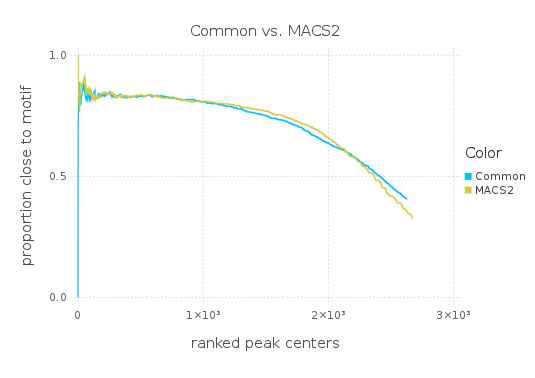

In [8]:
motifs = open(f->read_peaks(f, "FIMO"), "$sharedDataDir/REST_MA0138.2_FIMO_p6.txt")
bigDataDir = "/scratch2/slund1/ENCSR000BQS_local"
plot_scores([
    "Common" => score_peaks(open(f->read_peaks(f, "bed2"), "$sharedDataDir/ENCFF002CHH_hg38.bed"), motifs),
    "MACS2" => score_peaks(open(f->read_peaks(f, "bed"), "$bigDataDir/local_remap2_pooled_q01_summits.bed"), motifs)
])

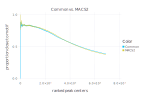

In [3]:
motifs = open(f->read_peaks(f, "FIMO"), "$sharedDataDir/REST_MA0138.2_FIMO_p6.txt")
bigDataDir = "/scratch2/slund1/ENCSR000BQS_local"
plot_scores([
    "Common" => score_peaks(open(f->read_peaks(f, "bed2"), "$sharedDataDir/ENCFF002CHH_hg38.bed"), motifs),
    "MACS2" => score_peaks(open(f->read_peaks(f, "bed"), "$bigDataDir/local_remap2_pooled_q01_summits.bed"), motifs)
])

<h3>Compare MACS2 with PureSeq7 forward control vs. matched control</h3>

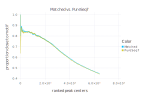

In [6]:
motifs = open(f->read_peaks(f, "FIMO"), "$sharedDataDir/REST_MA0138.2_FIMO_p6.txt")
bigDataDir = "/scratch2/slund1/ENCSR000BQS_notebook"
plot_scores([
    "Matched" => score_peaks(open(f->read_peaks(f, "bed"), "$bigDataDir/ENCFF000NYK_matched_ENCFF000ODO_summits.bed"), motifs),
    "PureSeq7" => score_peaks(open(f->read_peaks(f, "bed"), "$bigDataDir/ENCFF000NYK_pred7_w50_summits.bed"), motifs)
])

<h3>Compare MACS2 with PureSeq35 forward and reverse control vs. matched control</h3>

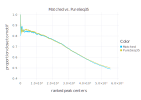

In [12]:
motifs = open(f->read_peaks(f, "FIMO"), "$sharedDataDir/REST_MA0138.2_FIMO_p6.txt")
bigDataDir = "/scratch2/slund1/ENCSR000BQS_notebook"
plot_scores([
    "Matched" => score_peaks(open(f->read_peaks(f, "bed"), "$bigDataDir/ENCFF000NYK_matched_ENCFF000ODO_summits.bed"), motifs),
    "PureSeq35" => score_peaks(open(f->read_peaks(f, "bed"), "$bigDataDir/ENCFF000NYK_pred35fr_w50_summits.bed"), motifs)
])

<h3>Compare MACS2 with PureSeq35 forward and reverse control vs. matched control qval 0.01</h3>

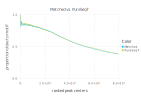

In [10]:
motifs = open(f->read_peaks(f, "FIMO"), "$sharedDataDir/REST_MA0138.2_FIMO_p6.txt")
bigDataDir = "/scratch2/slund1/ENCSR000BQS_notebook"
plot_scores([
    "Matched" => score_peaks(open(f->read_peaks(f, "bed"), "$bigDataDir/ENCFF000NYK_matched_ENCFF000ODO_q1_summits.bed"), motifs),
    "PureSeq35" => score_peaks(open(f->read_peaks(f, "bed"), "$bigDataDir/ENCFF000NYK_pred35fr_w50_q1_summits.bed"), motifs)
])

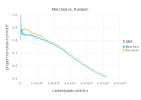

In [11]:
motifs = open(f->read_peaks(f, "FIMO"), "$sharedDataDir/REST_MA0138.2_FIMO_p6.txt")
bigDataDir = "/scratch2/slund1/ENCSR000BQS_notebook"
plot_scores([
    "Matched" => score_peaks(open(f->read_peaks(f, "bed"), "$bigDataDir/ENCFF000NYK_matched_ENCFF000ODO_summits.bed"), motifs),
    "Random" => score_peaks(open(f->read_peaks(f, "bed"), "$bigDataDir/ENCFF000NYK_rand_ENCFF000ODZ_summits.bed"), motifs)
])

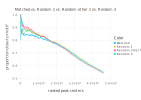

In [16]:
motifs = open(f->read_peaks(f, "FIMO"), "$sharedDataDir/REST_MA0138.2_FIMO_p6.txt")
bigDataDir = "/scratch2/slund1/ENCSR000BQS_notebook"
plot_scores([
    "Matched" => score_peaks(open(f->read_peaks(f, "bed"), "$bigDataDir/ENCFF000NYK_matched_ENCFF000ODO_summits.bed"), motifs),
    "Random 3" => score_peaks(open(f->read_peaks(f, "bed"), "$bigDataDir/ENCFF000NYK_rand_ENCFF000ODZ_ODZ_OEB_summits.bed"), motifs),
    "Random 1" => score_peaks(open(f->read_peaks(f, "bed"), "$bigDataDir/ENCFF000NYK_rand_ENCFF000ODZ_summits.bed"), motifs),
    "Random other 1" => score_peaks(open(f->read_peaks(f, "bed"), "$bigDataDir/ENCFF000NYK_rand_ENCFF000RBV_summits.bed"), motifs),
])

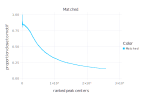

In [17]:
motifs = open(f->read_peaks(f, "FIMO"), "$sharedDataDir/REST_MA0138.2_FIMO_p6.txt")
bigDataDir = "/scratch2/slund1/ENCSR000BQS_notebook"
plot_scores([
    "Matched" => score_peaks(open(f->read_peaks(f, "bed"), "$bigDataDir/ENCFF000NYK_matched_ENCFF000ODO_q5_summits.bed"), motifs)
])

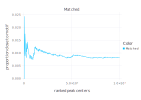

In [30]:
randPeaks = ChromosomePosition[]
for i in 1:10000
    push!(randPeaks, pos2chrpos(rand(1:3200000000), ReferenceContigs_hg38))
end
plot_scores([
    "Matched" => score_peaks(randPeaks, motifs)
])

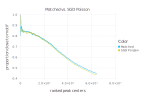

In [6]:
motifs = open(f->read_peaks(f, "FIMO"), "$sharedDataDir/REST_MA0138.2_FIMO_p6.txt")
bigDataDir = "/scratch2/slund1/ENCSR000BQS_notebook"
plot_scores([
    "Matched" => score_peaks(open(f->read_peaks(f, "bed"), "$bigDataDir/ENCFF000NYK_matched_ENCFF000ODO_summits.bed"), motifs),
    "SGD Poisson" => score_peaks(open(f->read_peaks(f, "bed"), "/scratch2/slund1/pure-seq/macs_tests/bam_files/ENCFF000NYK_poisson_sgd_35_q1_summits.bed"), motifs)
])

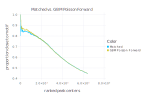

In [7]:
motifs = open(f->read_peaks(f, "FIMO"), "$sharedDataDir/REST_MA0138.2_FIMO_p6.txt")
bigDataDir = "/scratch2/slund1/ENCSR000BQS_notebook"
plot_scores([
    "Matched" => score_peaks(open(f->read_peaks(f, "bed"), "$bigDataDir/ENCFF000NYK_matched_ENCFF000ODO_summits.bed"), motifs),
    "GBM Poisson Forward" => score_peaks(open(f->read_peaks(f, "bed"), "/scratch2/slund1/pure-seq/macs_tests/bam_files/ENCFF000NYK_poisson_gbm_480f_q1_summits.bed"), motifs)
])

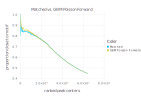

In [12]:
motifs = open(f->read_peaks(f, "FIMO"), "$sharedDataDir/REST_MA0138.2_FIMO_p6.txt")
bigDataDir = "/scratch2/slund1/ENCSR000BQS_notebook"
plot_scores([
    "Matched" => score_peaks(open(f->read_peaks(f, "bed"), "$bigDataDir/ENCFF000NYK_matched_ENCFF000ODO_summits.bed"), motifs),
    "GBM Poisson Forward" => score_peaks(open(f->read_peaks(f, "bed"), "/scratch2/slund1/pure-seq/macs_tests/bam_files/ENCFF000NYK_poisson_gbm_480f_q1_w500_summits.bed"), motifs)
])

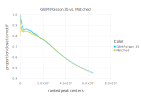

In [14]:
motifs = open(f->read_peaks(f, "FIMO"), "$sharedDataDir/REST_MA0138.2_FIMO_p6.txt")
bigDataDir = "/scratch2/slund1/ENCSR000BQS_notebook"
plot_scores([
    "Matched" => score_peaks(open(f->read_peaks(f, "bed"), "$bigDataDir/ENCFF000NYK_matched_ENCFF000ODO_summits.bed"), motifs),
    "GBM Poisson 35" => score_peaks(open(f->read_peaks(f, "bed"), "/scratch2/slund1/pure-seq/macs_tests/bam_files/ENCFF000NYK_poisson_gbm35_q1_summits.bed"), motifs)
])

In [95]:
directResults = readdlm("/tmp/results.txt");
predResults = readdlm("/tmp/results3.txt");

In [101]:
peaksNYK_ODO = open(f->read_peaks(f, "bed"), "$bigDataDir/ENCFF000NYK_matched_ENCFF000ODO_q1_summits.bed")
peaksNYK_2ECP = open(f->read_peaks(f, "bed"), "/scratch2/slund1/pure-seq/macs_tests/ENCFF000NYK_matched_ENCFF002ECP_q1_summits.bed")
peaksNYK = open(f->read_peaks(f, "bed"), "/scratch2/slund1/pure-seq/macs_tests/ENCFF000NYK_q1_summits.bed")
peaksNYN = open(f->read_peaks(f, "bed"), "/scratch2/slund1/pure-seq/macs_tests/ENCFF000NYN_q1_summits.bed")
peaksNYN_SGD35 = open(f->read_peaks(f, "bed"), "/scratch2/slund1/pure-seq/macs_tests/ENCFF000NYN_SGD_35_q1_correct_summits.bed")
peaksNYN_ODO = open(f->read_peaks(f, "bed"), "/scratch2/slund1/pure-seq/macs_tests/ENCFF000NYN_matched_ENCFF000ODO_q1_summits.bed")
peaksODO = open(f->read_peaks(f, "bed"), "/scratch2/slund1/pure-seq/macs_tests/ENCFF000ODO_q1_summits.bed");

In [37]:
length(peakNYN)

14028

In [42]:
using KDTrees

In [45]:
treeNYN = KDTree(map(x->x.pos, peakNYN))

LoadError: `KDTree{T<:FloatingPoint}` has no method matching KDTree{T<:FloatingPoint}(::Array{Int64,1})
while loading In[45], in expression starting on line 1

In [59]:
function find_nearby(peak, peaks)
    for i in 1:length(peaks)
        if abs(peak.pos - peaks[i].pos) < 50 && peak.chr == peaks[i].chr
            return true
        end
    end
    return false
end

find_nearby (generic function with 1 method)

In [60]:
filteredPeaksNYK = ChromosomePosition[]
for i in 1:length(peakNYK)
    if find_nearby(peakNYK[i], peakNYN)
        push!(filteredPeaksNYK, peakNYK[i])
    end
end

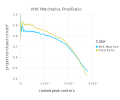

In [111]:
motifs = open(f->read_peaks(f, "FIMO"), "$sharedDataDir/REST_MA0138.2_FIMO_p6.txt")
bigDataDir = "/scratch2/slund1/ENCSR000BQS_notebook"
set_default_plot_size(12cm,10cm)
plot_scores([
    "NYK Matched" => data["NYK matched"],#score_peaks(peaksNYK_ODO, motifs),
    #"NYK" => score_peaks(peaksNYK, motifs),
    #"NYN_ODO" => score_peaks(peaksNYN_ODO, motifs),
    #"NYK_2ECP" => score_peaks(peaksNYK_2ECP, motifs),
    #"NYN" => score_peaks(peaksNYN, motifs),
    #"ODO" => score_peaks(peaksODO, motifs),
    #"GBM Poisson 35" => score_peaks(open(f->read_peaks(f, "bed"), "/scratch2/slund1/pure-seq/macs_tests/bam_files/ENCFF000NYK_poisson_gbm35_correct_q1_summits.bed"), motifs),
    #"Direct Score GBM Poisson 35" => rank_precision(directResults),
    "Pred Ratio" => precision_recall(predResults)
    #"GBM Poisson 35" => score_peaks(open(f->read_peaks(f, "bed"), "/scratch2/slund1/pure-seq/macs_tests/bam_files/ENCFF000NYK_poisson_gbm35_q1_summits.bed"), motifs)
])

In [120]:
draw(SVG("/tmp/myplot2.svg", 13cm, 10cm), Out[119])

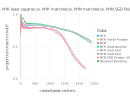

In [119]:
motifs = open(f->read_peaks(f, "FIMO"), "$sharedDataDir/REST_MA0138.2_FIMO_p6.txt")
bigDataDir = "/scratch2/slund1/ENCSR000BQS_notebook"
#set_default_plot_size(20cm,17cm)
set_default_plot_size(13cm,10cm)
plot_scores([
    "NYK matched" => data["NYK matched"],
    "NYK" => data["NYK"],
    "NYN matched" => data["NYN matched"],
    "NYN" => data["NYN"],
    "NYN SGD Poisson 35" => data["NYN SGD Poisson 35"],
    "NYK linear Poisson" => data["NYK linear Poisson"],
    "NYK least squares" => data["NYK least squares"],
    "Gradient Boosting" => data["Gradient Boosting"]
])

In [108]:
data = [
    "NYK matched" => score_peaks(peaksNYK_ODO, motifs),
    "NYK" => score_peaks(peaksNYK, motifs),
    "NYN matched" => score_peaks(peaksNYN_ODO, motifs),
    #"NYK_2ECP" => score_peaks(peaksNYK_2ECP, motifs),
    "NYN" => score_peaks(peaksNYN, motifs),
    "NYN SGD Poisson 35" => score_peaks(peaksNYN_SGD35, motifs),
    #"ODO" => score_peaks(peaksODO, motifs),
    "NYK GBM pred ratio" => precision_recall(predResults),
    "NYK linear Poisson" => score_peaks(open(f->read_peaks(f, "bed"), "/scratch2/slund1/pure-seq/macs_tests/bam_files/ENCFF000NYK_poisson_sgd_35_q1_summits.bed"), motifs),
    "NYK least squares" => score_peaks(open(f->read_peaks(f, "bed"), "$bigDataDir/ENCFF000NYK_pred35fr_w50_summits.bed"), motifs),
    #"GBM Poisson 35" => score_peaks(open(f->read_peaks(f, "bed"), "/scratch2/slund1/pure-seq/macs_tests/bam_files/ENCFF000NYK_poisson_gbm35_correct_q1_summits.bed"), motifs),
    #"Direct Score GBM Poisson 35" => rank_precision(directResults),
    "Gradient Boosting" => score_peaks(open(f->read_peaks(f, "bed"), "/scratch2/slund1/pure-seq/macs_tests/bam_files/ENCFF000NYK_poisson_gbm35_q1_summits.bed"), motifs)
    #"Random 1" => score_peaks(open(f->read_peaks(f, "bed"), "$bigDataDir/ENCFF000NYK_rand_ENCFF000ODZ_summits.bed"), motifs)
];

In [ ]:
X = zeros(length(keys(data)))
writedlm("/tmp/plot_data/NYK_

In [87]:
draw(SVG("/tmp/big_perf_plot.svg", 10inch, 7inch), Out[84])

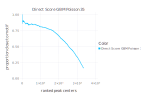

In [78]:
motifs = open(f->read_peaks(f, "FIMO"), "$sharedDataDir/REST_MA0138.2_FIMO_p6.txt")
bigDataDir = "/scratch2/slund1/ENCSR000BQS_notebook"
plot_scores([
    "Direct Score GBM Poisson 35" => precision_recall(directResults)
])

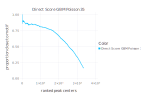

In [78]:
motifs = open(f->read_peaks(f, "FIMO"), "$sharedDataDir/REST_MA0138.2_FIMO_p6.txt")
bigDataDir = "/scratch2/slund1/ENCSR000BQS_notebook"
plot_scores([
    "Direct Score GBM Poisson 35" => precision_recall(directResults)
])

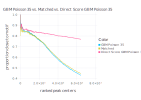

In [23]:
motifs = open(f->read_peaks(f, "FIMO"), "$sharedDataDir/REST_MA0138.2_FIMO_p6.txt")
bigDataDir = "/scratch2/slund1/ENCSR000BQS_notebook"
plot_scores([
    "Matched" => score_peaks(open(f->read_peaks(f, "bed"), "$bigDataDir/ENCFF000NYK_matched_ENCFF000ODO_summits.bed"), motifs),
    "GBM Poisson 35" => score_peaks(open(f->read_peaks(f, "bed"), "/scratch2/slund1/pure-seq/macs_tests/bam_files/ENCFF000NYK_poisson_gbm35_correct_q1_summits.bed"), motifs),
    "Direct Score GBM Poisson 35" => rank_precision(directResults)
])

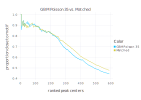

In [19]:
motifs = open(f->read_peaks(f, "FIMO"), "$sharedDataDir/REST_MA0138.2_FIMO_p6.txt")
bigDataDir = "/scratch2/slund1/ENCSR000BQS_notebook"
plot_scores([
    "Matched" => score_peaks(filter_peaks(open(f->read_peaks(f, "bed"), "$bigDataDir/ENCFF000NYK_matched_ENCFF000ODO_summits.bed"), "chr1"), motifs),
    "GBM Poisson 35" => score_peaks(filter_peaks(open(f->read_peaks(f, "bed"), "/scratch2/slund1/pure-seq/macs_tests/bam_files/ENCFF000NYK_poisson_gbm35_correct_q1_summits.bed"), "chr1"), motifs)
])

In [10]:
function filter_peaks(peaks, chr)
    newPeaks = ChromosomePosition[]
    for peak in peaks
        if peak.chr == chr
            push!(newPeaks, peak)
        end
    end
    newPeaks
end

filter_peaks (generic function with 1 method)

In [ ]:
#run(`macs2 callpeak -t ENCFF000NYK.bam -c ENCFF000NYK_pred7_w50.bam --q 0.01 -f BAM -g hs -n ENCFF000NYK_pred7_w50`)

In [ ]:
# peaksCommon = open(f->read_peaks(f, "bed2"), "$dataDir/ENCFF002CHH_hg38.bed")
# #peaksMACSB = GZip.open(f->read_peaks(f, "narrowPeak"), "$dataDir/ENCSR000BQS.peaks.narrowPeak.gz")
# #peaksMACS = open(f->read_peaks(f, "narrowPeak"), "$dataDir/ENCSR000BQS_peak.narrowPeak")
# #peaksMACSA = open(f->read_peaks(f, "bed2"), "$dataDir/test_peaks_hg38.bed")
# peaksMACSA = open(f->read_peaks(f, "bed"), "/scratch2/slund1/ENCSR000BQS_local/local_remap2_pooled_q01_summits.bed")
# #peaksMACSA = open(f->read_peaks(f, "bed"), "/scratch2/slund1/ENCSR000BQS_local/local_pooled_q001_summits.bed")
# peaksMACSB = open(f->read_peaks(f, "bed"), "/scratch2/slund1/ENCSR000BQS_local/local_pooled_q01_summits.bed")
# #peaksMACS = open(f->read_peaks(f, "narrowPeak"), "$dataDir/ENCSR000BQS_hg38peaks.narrowPeak")
# motifs = open(f->read_peaks(f, "FIMO"), "$dataDir/REST_MA0138.2_FIMO_p6.txt");